In [25]:
import pandas as pd
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV
from bayes_opt import BayesianOptimization
from joblib import dump, load
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("used_cars_data.csv")

In [ ]:
def augment_data(df, features, fraction=0.05):
    """
    Augment data by adding jittering.
    
    Parameters:
    - df: DataFrame to augment.
    - features: List of feature columns to which jittering should be applied.
    - fraction: Fraction of noise to add to the data.
    
    Returns:
    - Augmented DataFrame.
    """
    augmented_df = df.copy()
    for feature in features:
        noise = np.random.normal(0, fraction * df[feature].std(), size=df[feature].shape)
        augmented_df[feature] = df[feature] + noise
    return augmented_df


In [ ]:
# Augment the data
augmented_df = augment_data(df, features=['mileage (kms)', 'year'])


## Data Preprocessing

In [4]:
enc = OneHotEncoder(handle_unknown='ignore')

In [5]:
X = df[['brand', 'fuel', 'gearbox']]

In [6]:
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [7]:
X_features = pd.DataFrame(enc.transform(df[['brand', 'fuel', 'gearbox']]).toarray())


## Feature Engineering

Calculate the age of the car and other potential features

In [8]:
year = datetime.datetime.now().year

In [9]:
df['age'] = year - df['year']
df['mileage_per_year'] = df['mileage (kms)'] / df['age']
X_num = df[['age', 'mileage (kms)', 'mileage_per_year']]
y = df['price (eur)']

In [10]:
X = pd.concat([X_num, X_features], axis=1)

In [11]:
X.columns = X.columns.astype(str)

Feature Selection using Recursive Feature Elimination with cross-validation (RFECV)

RFECV helps in selecting the most important features for the model.

In [12]:
selector = RFECV(estimator=GradientBoostingRegressor(), step=1, cv=StratifiedKFold(5))
X_selected = selector.fit_transform(X, y)


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Model Training with Cross-validation

StratifiedKFold ensures that each fold has the same proportion of observations with a given label.

In [13]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hyperparameter tuning with Bayesian Optimization for Gradient Boosting

Bayesian Optimization helps in finding the best hyperparameters for the model.

In [14]:
def optimize_gb(n_estimators, learning_rate, max_depth, subsample, min_samples_split, min_samples_leaf):
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        n_iter_no_change=10,
        validation_fraction=0.1,
        tol=0.01
    )
    return cross_val_score(model, X_selected, y, cv=kf, scoring='neg_mean_squared_error').mean()


In [15]:
optimizer = BayesianOptimization(
    f=optimize_gb,
    pbounds={
        "n_estimators": (50, 300),
        "learning_rate": (0.01, 0.3),
        "max_depth": (3, 10),
        "subsample": (0.5, 1.0),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 10)
    },
    random_state=42,
)

In [16]:
optimizer.maximize(n_iter=15)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -2.809e+0 | 0.1186    | 9.655     | 7.588     | 6.789     | 89.0      | 0.578     |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 2         | -2.767e+0 | 0.02684   | 9.063     | 6.41      | 7.665     | 55.15     | 0.985     |
| 3         | -2.454e+0 | 0.2514    | 4.486     | 2.636     | 3.467     | 126.1     | 0.7624    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 4         | -2.568e+0 | 0.1353    | 5.039     | 6.507     | 3.116     | 123.0     | 0.6832    |
| 5         | -2.637e+0 | 0.1423    | 8.496     | 2.797     | 6.114     | 198.1     | 0.5232    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 6         | -2.276e+0 | 0.2012    | 4.078     | 1.393     | 4.306     | 132.4     | 0.847     |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 7         | -2.25e+07 | 0.3       | 3.0       | 1.0       | 4.066     | 144.9     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 8         | -2.522e+0 | 0.071     | 9.947     | 2.925     | 7.608     | 173.9     | 0.6438    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 9         | -2.623e+0 | 0.01      | 10.0      | 1.0       | 10.0      | 140.5     | 0.5       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 10        | -2.451e+0 | 0.3       | 3.0       | 4.936     | 2.0       | 139.1     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 11        | -2.617e+0 | 0.2212    | 6.057     | 4.796     | 2.243     | 68.91     | 0.8332    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 12        | -2.679e+0 | 0.1314    | 8.078     | 5.69      | 7.933     | 69.55     | 0.5163    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 13        | -2.563e+0 | 0.02186   | 3.806     | 2.307     | 3.811     | 150.6     | 0.795     |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 14        | -2.313e+0 | 0.3       | 3.0       | 1.0       | 5.835     | 141.2     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 15        | -2.121e+0 | 0.3       | 3.0       | 1.0       | 9.318     | 131.5     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 16        | -2.509e+0 | 0.3       | 3.0       | 5.603     | 10.0      | 131.6     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 17        | -2.342e+0 | 0.2544    | 6.934     | 1.009     | 9.826     | 130.2     | 0.8671    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 18        | -2.435e+0 | 0.2465    | 3.195     | 1.446     | 9.39      | 133.4     | 0.7116    |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 19        | -2.448e+0 | 0.3       | 3.579     | 1.0       | 7.873     | 130.4     | 1.0       |


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


| 20        | -2.176e+0 | 0.219     | 3.727     | 1.311     | 5.613     | 132.5     | 0.8821    |


# Hyperparameter Tuning

Train the best model using the best hyperparameters


In [17]:
best_params = optimizer.max['params']
regr_best = GradientBoostingRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=0.01
)

In [18]:
regr_best.fit(X_selected, y)


GradientBoostingRegressor(learning_rate=0.3, min_samples_split=9,
                          n_estimators=131, n_iter_no_change=10, tol=0.01)

## Model Evaluation

Calculate the RMSE and MAE to evaluate the model's performance.

In [19]:
y_pred = regr_best.predict(X_selected)
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)


Helps in understanding which features are most important for the model.

In [21]:
feature_importance = regr_best.feature_importances_
sorted_idx = feature_importance.argsort()

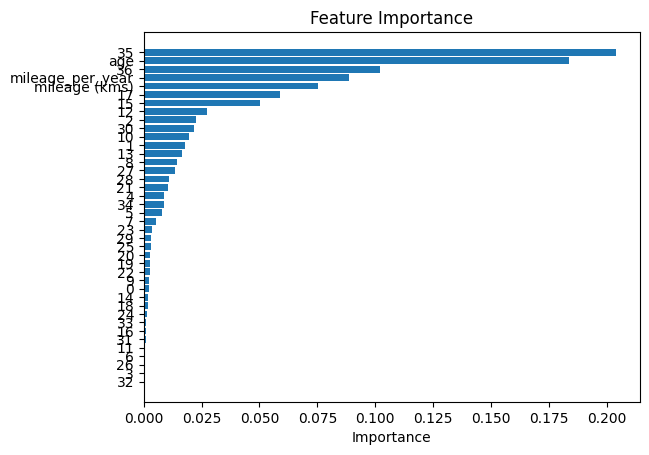

In [22]:
plt.barh(range(X_selected.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_selected.shape[1]), X.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [23]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 3006.620858118147
Mean Absolute Error (MAE): 1682.9424746694535


## Saving the model

In [24]:
dump(regr_best, 'model_best.joblib')
dump(enc, 'encoder.joblib')

['encoder.joblib']